In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import GaussianNB

df=pd.read_csv("Premierlig-2020-2023-maçlar.csv")
df2=pd.read_csv("Premierlig-2020-2017-maçlar.csv")
df3=pd.read_csv("Premierlig-2017-2010-maçlar.csv")
df4=pd.read_csv("2023_2024_Premier_Lig.csv")
#df4[df4['Date']!='2024-04-03']
df = pd.concat([df, df2,df3,df4], ignore_index=True)
df.drop(columns='Unnamed: 0',inplace=True)
df.drop(columns='Notes',inplace=True)
uniq=df[['Team','Season']].drop_duplicates()
uniq.shape
ortalama = df.groupby(['Team', 'Season'])['Attendance'].mean().reset_index()
ortalama_Dist = df.groupby(['Team', 'Season'])['Dist'].mean().reset_index()
ortalama
for index, row in df.iterrows():
    if pd.isnull(row['Attendance']):
        team = row['Team']
        season = row['Season']
        mean_attendance = ortalama[(ortalama['Team'] == team) & (ortalama['Season'] == season)]['Attendance'].values[0]
        df.at[index, 'Attendance'] = mean_attendance
for index, row in df.iterrows():
    if pd.isnull(row['Dist']):
        team = row['Team']
        season = row['Season']
        mean_attendance = ortalama_Dist[(ortalama_Dist['Team'] == team) & (ortalama_Dist['Season'] == season)]['Dist'].values[0]
        df.at[index, 'Dist'] = mean_attendance
        
df.drop('FK',axis=1,inplace=True)
df = df[~df['Opponent'].isin(['Norwich City', 'Watford', 'West Bromwich Albion'])]


#df.dropna(inplace=True)
encoder=LabelEncoder()
df['Opponent'].replace({'West Ham':'West Ham United','Newcastle Utd':'Newcastle United',"Nott'ham Forest":'Nottingham Forest','Wolves':'Wolverhampton Wanderers','Manchester Utd':'Manchester United','Brighton':'Brighton and Hove Albion','Tottenham':'Tottenham Hotspur','Sheffield Utd':'Sheffield United','West Brom':'West Bromwich Albion','Huddersfield':'Huddersfield Town'},inplace=True)
df['Encoded_Team']=encoder.fit_transform(df['Team'])
df['Encoded_Opponent']=encoder.transform(df['Opponent'])
df['Encoded_Venue']=encoder.fit_transform(df['Venue'])
df['Encoded_Result']=encoder.fit_transform(df['Result'])
df['Encoded_Matchweek']=encoder.fit_transform(df['Round'])
df['Encoded_Referee']=encoder.fit_transform(df['Referee'])
df['Date'] = pd.to_datetime(df['Date'])
df['Month']=df['Date'].dt.month
df['Days']=df['Date'].dt.day
scaler=MinMaxScaler()
df['Poss_away']=abs(1-df['Poss'])
df['Dist']
df.columns
df=df[df['Comp']=='Premier League']
df = df.drop_duplicates(subset=['Date', 'Encoded_Referee'])

In [22]:
starting_elo = 1500
elo_ratings = {team: starting_elo for team in df['Team'].unique()}

def update_elo(winner, loser, winner_elo, loser_elo, k=32, power_factor=1):
    # Güç faktörünü kazanan ve kaybeden takımların ELO puanlarına uygula
    winner_elo *= power_factor
    loser_elo *= power_factor
    
    expected_winner = 1 / (1 + 10 ** ((loser_elo - winner_elo) / 400))
    expected_loser = 1 - expected_winner
    winner_new_elo = winner_elo + k * (1 - expected_winner)
    loser_new_elo = loser_elo + k * (0 - expected_loser)
    return winner_new_elo, loser_new_elo

def calculate_elo(df, elo_ratings, power_factor=1):
    # Her iterasyonda yeni bir elo_ratings kopyası oluşturuyoruz
    elo_ratings_copy = elo_ratings.copy()
    for index, row in df.iterrows():
        team = row['Team']
        opponent = row['Opponent']
        winner_elo_before = elo_ratings_copy[team]
        loser_elo_before = elo_ratings_copy[opponent]
        elo_team, elo_opponent = update_elo(team, opponent, elo_ratings_copy[team], elo_ratings_copy[opponent], power_factor=power_factor)
        # Sadece kaybeden takımın ELO puanı düşecek
        elo_ratings_copy[opponent] = elo_opponent
        df.at[index, 'Elo_Team'] = elo_team
        df.at[index, 'Elo_Opponent'] = elo_opponent
    return df

# Güç faktörünü belirleyin
power_factor = 1  # Örneğin

# ELO puanlarını hesaplayın
df = calculate_elo(df.copy(), elo_ratings.copy(), power_factor=power_factor)
df

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,...,Encoded_Opponent,Encoded_Venue,Encoded_Result,Encoded_Matchweek,Encoded_Referee,Month,Days,Poss_away,Elo_Team,Elo_Opponent
0,2022-08-07,16:30,Premier League,Matchweek 1,Sun,Away,W,2.0,0.0,West Ham United,...,28,0,2,0,18,8,7,74.0,1516.000000,1484.000000
1,2022-08-13,15:00,Premier League,Matchweek 2,Sat,Home,W,4.0,0.0,Bournemouth,...,2,1,2,11,7,8,13,66.0,1516.000000,1484.000000
2,2022-08-21,16:30,Premier League,Matchweek 3,Sun,Away,D,3.0,3.0,Newcastle United,...,18,0,0,22,9,8,21,68.0,1516.000000,1484.000000
3,2022-08-27,15:00,Premier League,Matchweek 4,Sat,Home,W,4.0,2.0,Crystal Palace,...,8,1,2,32,6,8,27,73.0,1516.000000,1484.000000
4,2022-08-31,19:30,Premier League,Matchweek 5,Wed,Home,W,6.0,0.0,Nottingham Forest,...,20,1,2,33,24,8,31,73.0,1516.000000,1484.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8944,2023-10-03,19:30,Premier League,Matchweek 2,Tue,Home,L,1.0,2.0,Burnley,...,5,1,1,11,25,10,3,48.0,684.077236,-46.708841
8955,2023-12-26,15:00,Premier League,Matchweek 19,Tue,Away,W,3.0,2.0,Sheffield United,...,21,0,2,10,30,12,26,48.0,684.735266,107.921877
8957,2024-01-12,19:45,Premier League,Matchweek 21,Fri,Away,D,1.0,1.0,Burnley,...,5,0,0,13,37,1,12,60.0,684.075974,-47.179739
8960,2024-02-10,15:00,Premier League,Matchweek 24,Sat,Home,L,1.0,3.0,Sheffield United,...,21,1,1,16,3,2,10,73.0,684.728194,106.798759


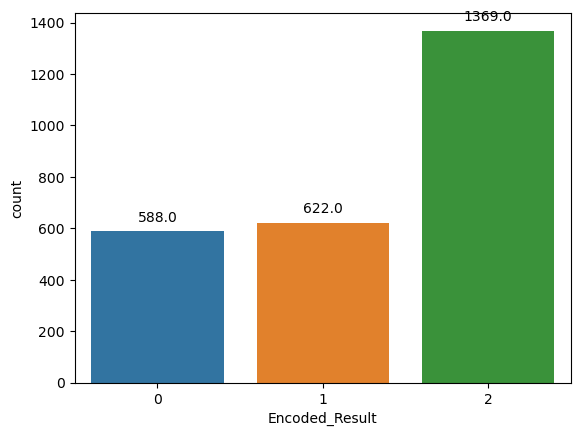

In [23]:
import seaborn as sns 
import matplotlib.pyplot as plt

# Assuming you have your DataFrame 'df' with a column 'Encoded_Result'

fig, ax = plt.subplots()  # Create figure and axis objects

sns.countplot(data=df, x='Encoded_Result', ax=ax)  # Pass the ax object

# Add annotations 
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 5),  # Offset slightly above the bar
                textcoords='offset points', 
                ha='center', va='bottom')

plt.show()


In [24]:
df[['Encoded_Result','Encoded_Team','Encoded_Opponent','Attendance','Encoded_Referee','Poss_away','xG','xGA','SoT','Sh','Encoded_Venue','Elo_Team','Elo_Opponent']].corr()['Encoded_Result'].sort_values(ascending=False)


Encoded_Result      1.000000
xG                  0.313978
SoT                 0.299628
Sh                  0.115929
Encoded_Venue       0.109032
Attendance          0.075393
Elo_Team            0.071994
Elo_Opponent        0.055885
Poss_away           0.034627
Encoded_Opponent   -0.003514
Encoded_Referee    -0.017206
Encoded_Team       -0.019614
xGA                -0.212044
Name: Encoded_Result, dtype: float64

C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


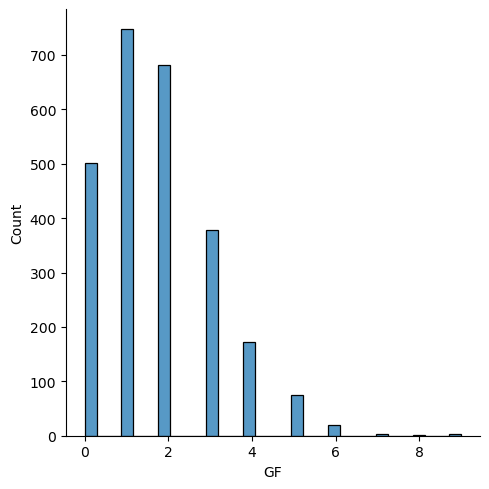

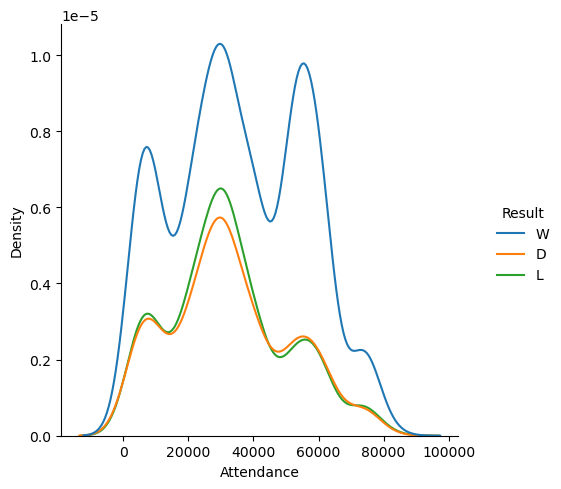

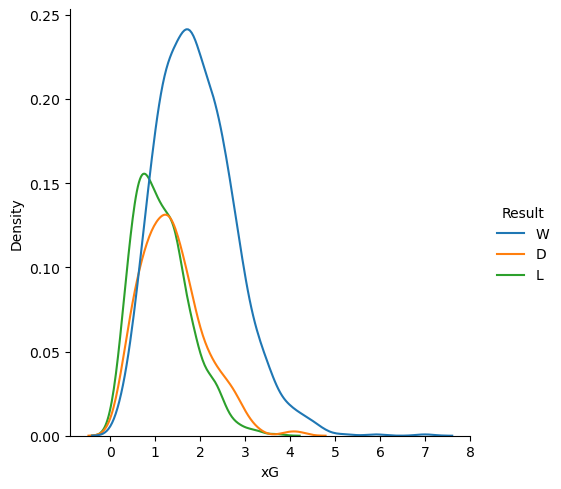

In [25]:
sns.displot(df['GF'])
sns.displot(df, x='Attendance', hue='Result', kind='kde')
sns.displot(df, x='xG', hue='Result', kind='kde')  # xG distribution by result

<Axes: xlabel='xG', ylabel='xGA'>

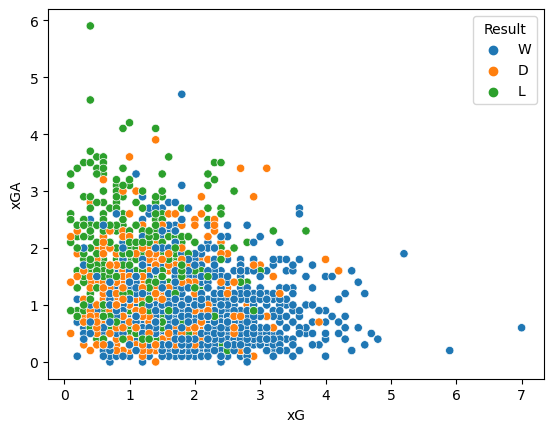

In [26]:
# Relationship between xG, xGA and results
sns.scatterplot(x='xG', y='xGA', hue='Result', data=df)

<Axes: xlabel='Venue', ylabel='Poss'>

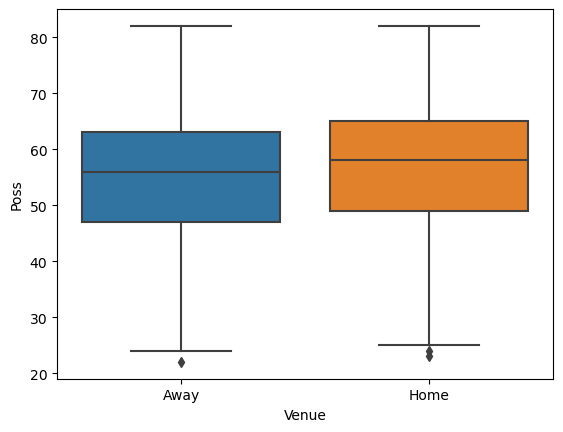

In [27]:
sns.boxplot(x='Venue', y='Poss', data=df) 

In [28]:
df_possession_trends = df.groupby(['Encoded_Venue', 'Result'])['Poss'].mean()
#df_possession_trends.unstack(level=0)
df_possession_trends

Encoded_Venue  Result
0              D         53.905063
               L         54.822751
               W         55.623729
1              D         57.647059
               L         56.864754
               W         57.172015
Name: Poss, dtype: float64

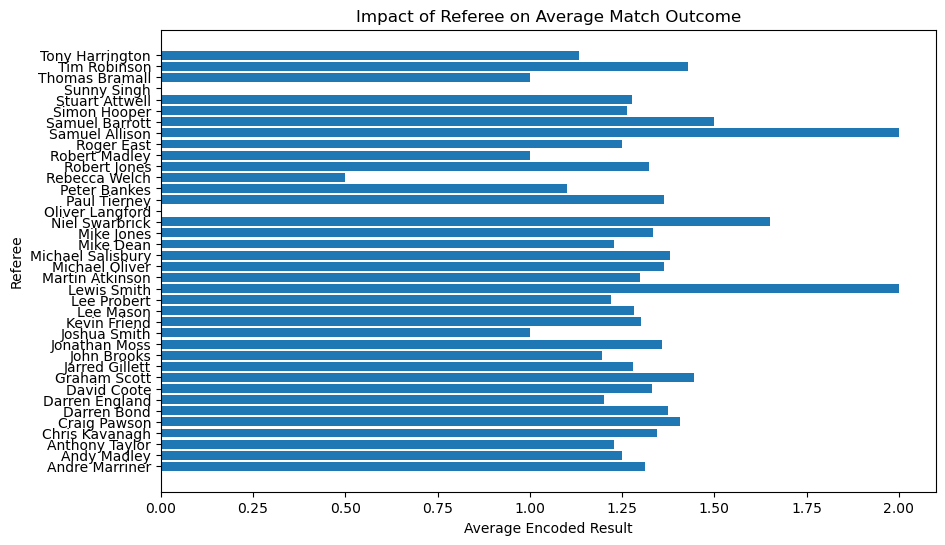

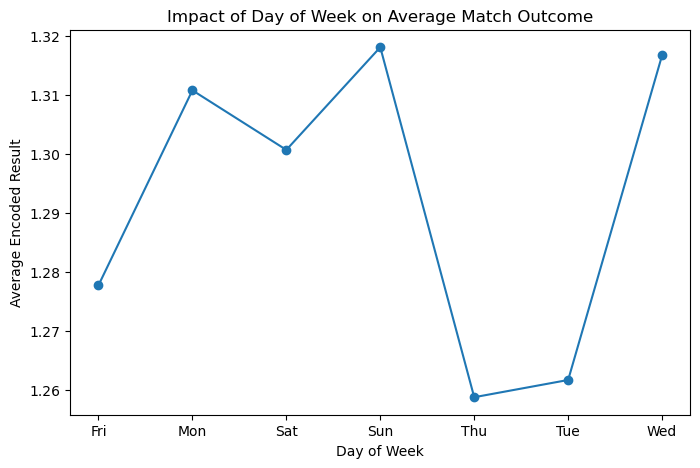

In [29]:
# Analyze impact of factors like referee, day of week, etc.
referee_effect = df.groupby('Referee')['Encoded_Result'].mean()


# Day-of-week effect
dow_effect = df.groupby('Day')['Encoded_Result'].mean()

plt.figure(figsize=(10, 6)) 
plt.barh(referee_effect.index, referee_effect.values)
plt.xlabel('Average Encoded Result')
plt.ylabel('Referee')
plt.title('Impact of Referee on Average Match Outcome')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(dow_effect.index, dow_effect.values, marker='o')  # Adding markers for clarity
plt.xlabel('Day of Week')
plt.ylabel('Average Encoded Result')
plt.title('Impact of Day of Week on Average Match Outcome')
plt.show()

In [64]:
from sklearn.preprocessing import StandardScaler
df_ai = df[['Encoded_Team', 'Encoded_Opponent', 'xG', 'xGA', 'SoT', 'Sh','Poss','Poss_away' ,'Elo_Team', 'Elo_Opponent', 'Encoded_Venue']]

X=df_ai.values
y = df[['Encoded_Result']].values
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=101)

In [65]:
classifiers = [
    ('Random Forest', RandomForestClassifier(criterion='log_loss', warm_start=True, class_weight='balanced')),
    ('Logistic Regression', LogisticRegression()),
    ('K Neighbors', KNeighborsClassifier()),
    ('Support Vector Machine', SVC()),
    ('AdaBoost', AdaBoostClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('Extra Trees', ExtraTreesClassifier()), 
    
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier())
]

for name, clf in classifiers:
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)

    print(f"-- {name} --")
    print(classification_report(y_test, preds))
    print('Accuracy:', accuracy_score(y_test, preds))
    print() 

C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_forest.py:780: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


-- Random Forest --
              precision    recall  f1-score   support

           0       0.38      0.15      0.22       117
           1       0.62      0.58      0.60       127
           2       0.69      0.89      0.78       272

    accuracy                           0.65       516
   macro avg       0.56      0.54      0.53       516
weighted avg       0.60      0.65      0.61       516

Accuracy: 0.6453488372093024

-- Logistic Regression --
              precision    recall  f1-score   support

           0       0.30      0.10      0.15       117
           1       0.58      0.62      0.60       127
           2       0.69      0.86      0.77       272

    accuracy                           0.63       516
   macro avg       0.52      0.53      0.51       516
weighted avg       0.58      0.63      0.59       516

Accuracy: 0.6317829457364341

-- K Neighbors --
              precision    recall  f1-score   support

           0       0.26      0.26      0.26       117
     

C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pleas

-- Support Vector Machine --
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       117
           1       0.66      0.38      0.48       127
           2       0.60      0.97      0.74       272

    accuracy                           0.60       516
   macro avg       0.42      0.45      0.41       516
weighted avg       0.48      0.60      0.51       516

Accuracy: 0.6046511627906976



C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\User

-- AdaBoost --
              precision    recall  f1-score   support

           0       0.37      0.12      0.18       117
           1       0.60      0.64      0.62       127
           2       0.69      0.87      0.77       272

    accuracy                           0.64       516
   macro avg       0.55      0.54      0.52       516
weighted avg       0.60      0.64      0.60       516

Accuracy: 0.6434108527131783



C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-- Gradient Boosting --
              precision    recall  f1-score   support

           0       0.33      0.12      0.17       117
           1       0.60      0.57      0.59       127
           2       0.69      0.89      0.78       272

    accuracy                           0.64       516
   macro avg       0.54      0.53      0.51       516
weighted avg       0.59      0.64      0.60       516

Accuracy: 0.6395348837209303



C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


-- Extra Trees --
              precision    recall  f1-score   support

           0       0.31      0.14      0.19       117
           1       0.57      0.49      0.53       127
           2       0.66      0.87      0.75       272

    accuracy                           0.61       516
   macro avg       0.51      0.50      0.49       516
weighted avg       0.56      0.61      0.57       516

Accuracy: 0.6085271317829457

-- Naive Bayes --
              precision    recall  f1-score   support

           0       0.28      0.13      0.18       117
           1       0.46      0.58      0.51       127
           2       0.69      0.76      0.72       272

    accuracy                           0.57       516
   macro avg       0.47      0.49      0.47       516
weighted avg       0.54      0.57      0.55       516

Accuracy: 0.5717054263565892

-- Decision Tree --
              precision    recall  f1-score   support

           0       0.28      0.30      0.29       117
           1 

C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)
rfc=RandomForestClassifier()
rfc.fit(X_train,y_train)
preds=rfc.predict(X_test)
print(classification_report(y_test,preds))

C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

           0       0.24      0.09      0.14       201
           1       0.51      0.48      0.49       201
           2       0.66      0.86      0.75       450

    accuracy                           0.59       852
   macro avg       0.47      0.48      0.46       852
weighted avg       0.53      0.59      0.54       852



In [58]:
x=29
y=8
filtered_data_1 = df[((df['Encoded_Team'] == x) & (df['Encoded_Opponent'] == y))].sort_values(by='Date',ascending=False).head(15)
filtered_data_1=filtered_data_1.drop_duplicates()
filtered_data_1 = filtered_data_1[['xG', 'xGA', 'SoT', 'Sh', 'Poss','Poss_away','Elo_Team', 'Elo_Opponent']]
result_mean = pd.DataFrame(filtered_data_1.mean()).transpose()
result_mean = result_mean[['xG', 'xGA', 'SoT', 'Sh','Poss','Poss_away', 'Elo_Team', 'Elo_Opponent']]
result_mean['Encoded_Team'] =x
result_mean['Encoded_Opponent'] = y
result_mean['Encoded_Venue'] = 1
result_mean = result_mean[['Encoded_Team','Encoded_Opponent','xG', 'xGA', 'SoT', 'Sh','Poss','Poss_away', 'Elo_Team', 'Elo_Opponent','Encoded_Venue']]

proba_preds = rfc.predict_proba(result_mean)
class_labels = rfc.classes_

# Tahmin edilen sınıfları ve olasılıkları göster
for i in range(len(proba_preds)):
    prob_class_pairs = [(prob, class_label) for prob, class_label in zip(proba_preds[i], class_labels)]
    prob_class_pairs.sort(reverse=True)  # Olasılıklara göre sırala
    print(f"Tahminler ve Olasılıklar:")
    for prob, class_label in prob_class_pairs:
        print(f"{prob:.2f} = {class_label}")
    print()

Tahminler ve Olasılıklar:
0.40 = 2
0.30 = 1
0.30 = 0



C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [55]:
pd.DataFrame(df[['Encoded_Team','Team']].value_counts()).reset_index().sort_values(by='Encoded_Team')

,Encoded_Team,Team,count
3,0,Arsenal,188
14,1,Aston Villa,80
17,2,Bournemouth,50
19,3,Brentford,41
11,4,Brighton and Hove Albion,95
16,5,Burnley,57
26,6,Cardiff City,4
5,7,Chelsea,182
12,8,Crystal Palace,94
13,9,Everton,90
